# Pràctica 3: Reconeixement de comandes de Veu
### Yufeng Chen i Raúl Castillo Moraz
##### 18 de Desembre de 2025

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
!pip3 install kagglehub
!pip3 install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [2]:
import kagglehub

kagglehub.login()  # Follow the prompts to log in to your Kaggle account
data_path = kagglehub.competition_download('tvd-2025-reconocimiento-de-comandos-de-voz')

100%|██████████| 4.55G/4.55G [00:38<00:00, 125MB/s]

Extracting files...


## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [ ]:
!pip3 install matplotlib
!pip3 install seaborn

In [ ]:
!pip3 install -U -q tensorflow==2.20.0  tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd


from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [4]:
DATASET_PATH = data_path+'/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command.

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands :', commands)

Commands : ['no' 'dog' 'left' 'stop' 'bird' 'seven' 'three' 'four' 'eight' 'down'
 'up' 'happy' 'house' 'wow' '_background_noise_' 'tree' 'right' 'zero'
 'sheila' 'bed' 'five' 'yes' 'two' 'marvin' 'six' 'off' 'one' 'nine' 'go'
 'cat' 'on']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [11]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

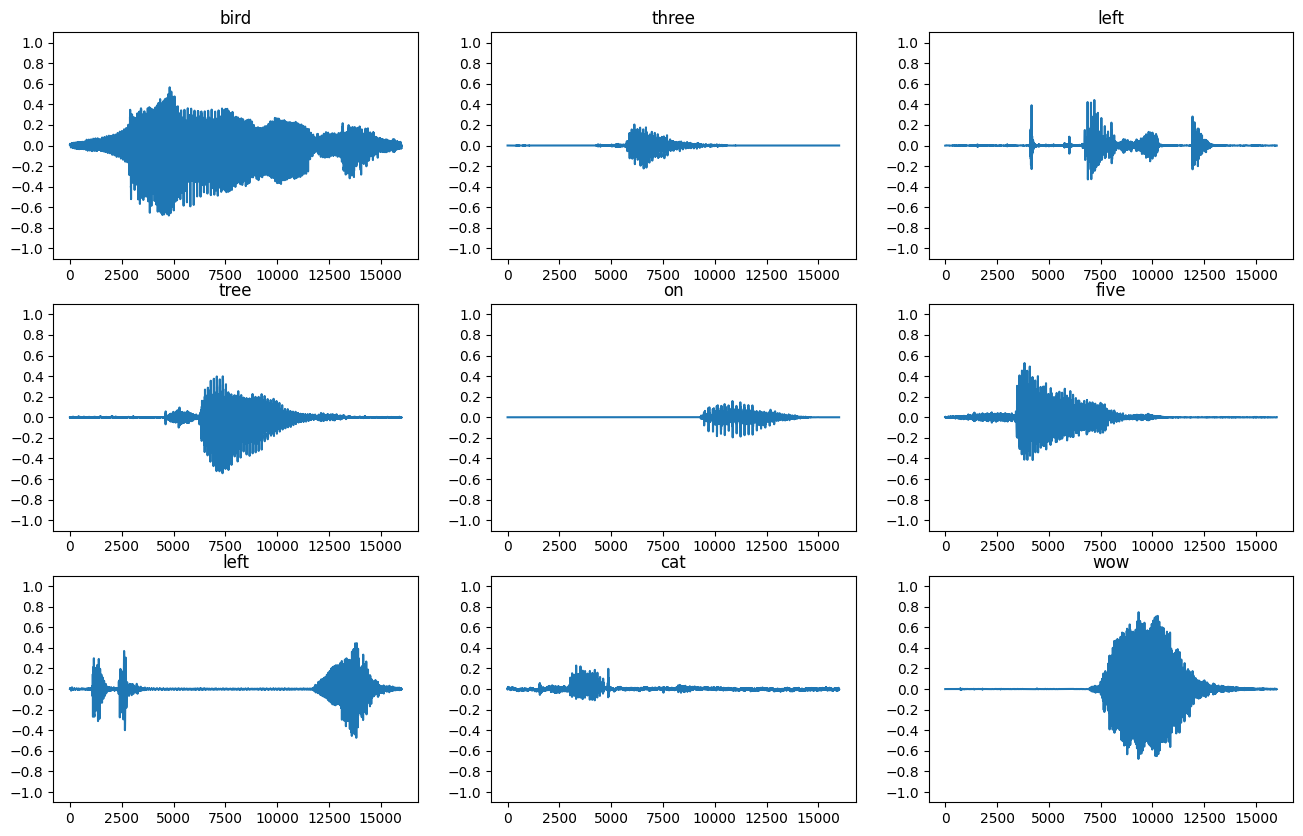

In [32]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_lineal_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # 480, 240, fft_length = 1024
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# Funcions auxiliars

Funció per convertir un waveform a un espectrograma MEL

In [14]:
def get_MEL_spectrogram(waveform):
    waveform = tf.cast(waveform, tf.float32)

    if waveform.shape[-1] == 1:
        waveform = tf.squeeze(waveform, axis=-1)

    # STFT
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128, fft_length=512)
    magnitude = tf.abs(stft) ** 2

    # Mel filter bank
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=128, num_spectrogram_bins=257, sample_rate=16000, lower_edge_hertz=0.0, upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(magnitude, mel_matrix)
    log_mel = tf.math.log(mel_spectrogram + 1e-6)

    # Dimensions
    if len(log_mel.shape) == 3:
        return tf.transpose(log_mel, perm=[0, 2, 1])
    else:
        return tf.transpose(log_mel)

def plot_MEL_spectrogram(spectrogram):
    plt.figure(figsize=(8, 3))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel("Time")
    plt.ylabel("Mel bins")
    plt.show()

Funció per convertir un waveform a un MFCC

In [15]:
def get_mfcc(waveform):

    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(128, num_spectrogram_bins, 16000, 0.0, 8000.0)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Compute MFCC
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    mfccs = mfccs[..., :13]
    return mfccs[..., tf.newaxis]

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_lineal_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

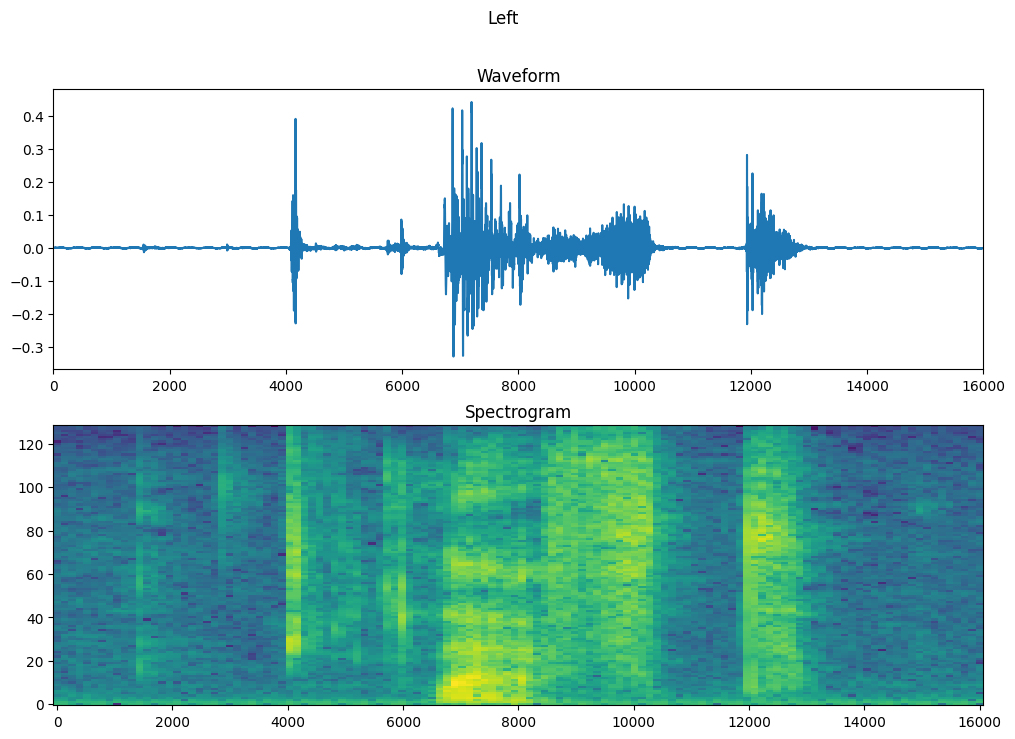

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Visualitzem el espectrograma MEL del mateix audio

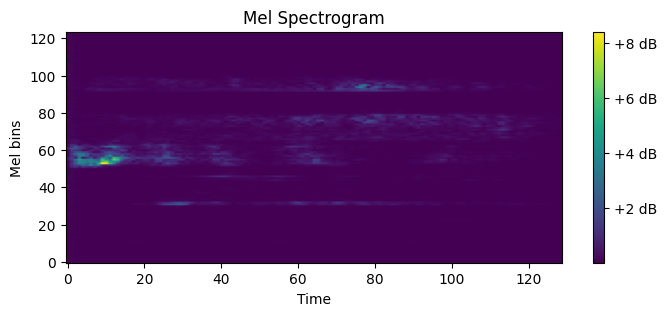

In [ ]:
plot_MEL_spectrogram(spectrogram)

Now, create spectrogram datasets from the audio datasets:

In [16]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_lineal_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_lineal_spectrogram_ds = make_spec_ds(train_ds)
val_lineal_spectrogram_ds = make_spec_ds(val_ds)
test_lineal_spectrogram_ds = make_spec_ds(test_ds)

train_lineal_spectrogram_ds = train_lineal_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_lineal_spectrogram_ds = val_lineal_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_lineal_spectrogram_ds = test_lineal_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Fem lo mateix per crear un dataset de espectrogrames MEL

In [17]:
def make_spec_ds_MEL(audio, label):
    spectrogram = get_MEL_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    return spectrogram, label

train_MEL_spectrogram_ds = train_ds.map(make_spec_ds_MEL, num_parallel_calls=tf.data.AUTOTUNE)
val_MEL_spectrogram_ds = val_ds.map(make_spec_ds_MEL, num_parallel_calls=tf.data.AUTOTUNE)
test_MEL_spectrogram_ds = test_ds.map(make_spec_ds_MEL, num_parallel_calls=tf.data.AUTOTUNE)

train_MEL_spectrogram_ds = train_MEL_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_MEL_spectrogram_ds = val_MEL_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MEL_spectrogram_ds = test_MEL_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Dataset de MFCC

In [18]:
def make_spec_ds_MFCC(audio, label):
    spectrogram = get_mfcc(audio)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    return spectrogram, label

train_MFCC_ds = train_ds.map(make_spec_ds_MFCC, num_parallel_calls=tf.data.AUTOTUNE)
val_MFCC_ds = val_ds.map(make_spec_ds_MFCC, num_parallel_calls=tf.data.AUTOTUNE)
test_MFCC_ds = test_ds.map(make_spec_ds_MFCC, num_parallel_calls=tf.data.AUTOTUNE)

train_MFCC_ds = train_MFCC_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms_lineal, example_spect_labels_lineal in train_lineal_spectrogram_ds.take(1):
  break

for example_spectrograms_MEL, example_spect_labels_MEL in train_MEL_spectrogram_ds.take(1):
  break

for example_spectrograms_MFCC, example_spect_labels_MFCC in train_MFCC_ds.take(1):
  break

#### Més exemples d'espectogrames MEL

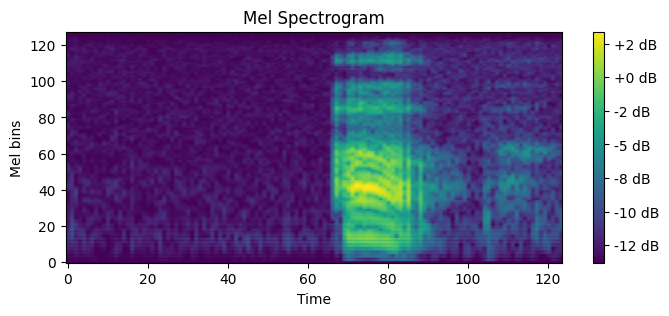

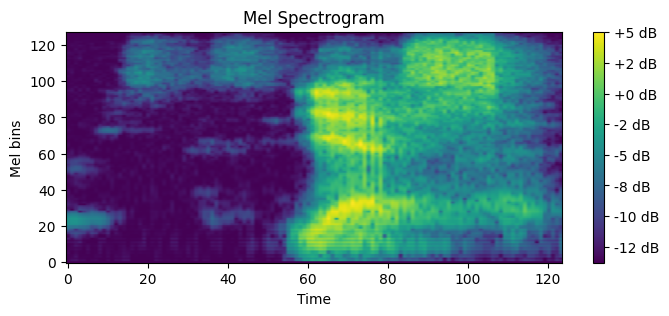

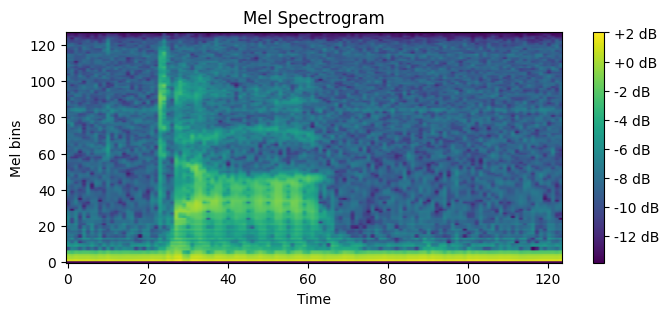

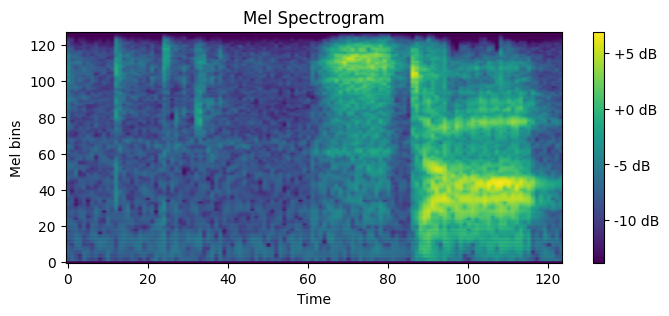

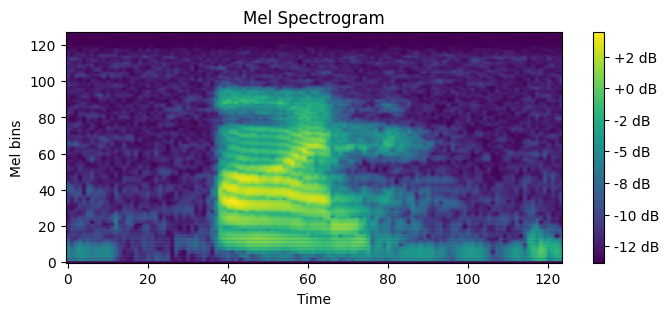

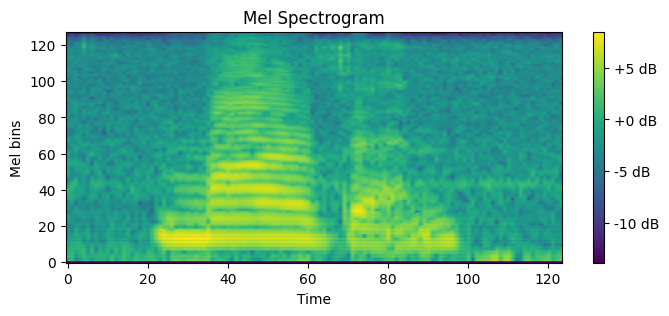

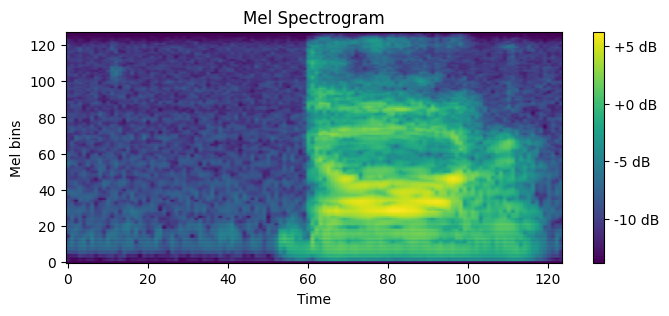

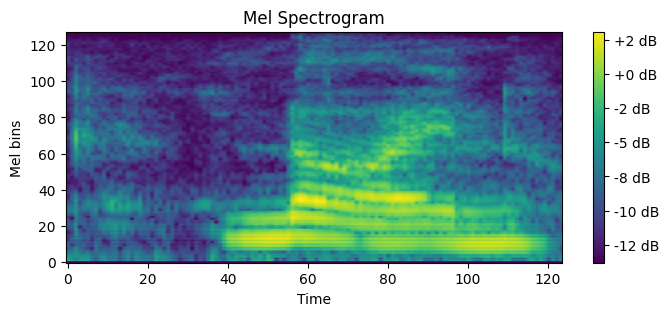

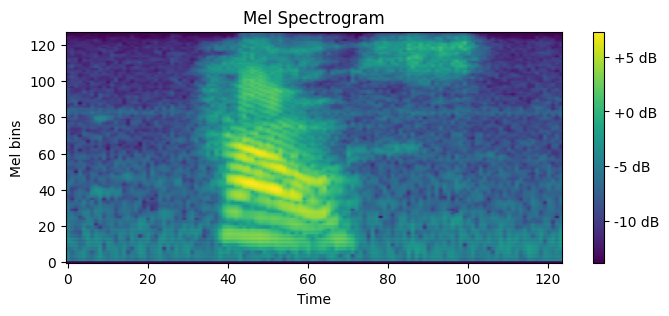

In [ ]:
rows = 3
cols = 3
n = rows*cols

for i in range(n):
    plot_MEL_spectrogram(example_spectrograms_MEL[i])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [20]:
# We provide some function you may find useful for your models

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

# Experiment del tipus de espectrograma

Comparem quin espectrograma obté els millors resultats en el model baseline

In [ ]:
input_shape = example_spectrograms_lineal.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer_lineal = layers.Normalization()
norm_layer_lineal.adapt(data=train_lineal_spectrogram_ds.map(map_func=lambda spec, label: spec))

base_model_lineal = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer_lineal,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

base_model_lineal.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
input_shape = example_spectrograms_MEL.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer_MEL = layers.Normalization()
norm_layer_MEL.adapt(data=train_MEL_spectrogram_ds.map(map_func=lambda spec, label: spec))

base_model_MEL = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer_MEL,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

base_model_MEL.summary()

Input shape: (128, 124, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
input_shape = example_spectrograms_MFCC.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer_MFCC = layers.Normalization()
norm_layer_MFCC.adapt(train_MFCC_ds.map(lambda spec, label: tf.squeeze(spec, axis=-1)))

base_model_MFCC = models.Sequential([
    layers.Input(shape=input_shape),                 # (124, 13, 1, 1)
    layers.Lambda(lambda x: tf.squeeze(x, axis=-1)),  # -> (124, 13, 1)
    layers.Resizing(32, 32),
    norm_layer_MFCC,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

base_model_MFCC.summary()

Input shape: (124, 13, 1, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 124, 13, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

Funció auxiliar que fa tot el pipeline d'entrenament i avaluació

In [21]:
def training_pipeline(train_data, val_data, test_data, model, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

    print(model.evaluate(test_data, return_dict=True))
    y_pred = model.predict(test_data)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test_data.map(lambda s,lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

    l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]
    df = pd.DataFrame(l, columns=['ID','labels'])
    df.to_csv('submission.csv', index=False)


Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.2470 - loss: 2.7050 - val_accuracy: 0.5062 - val_loss: 1.8085
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5413 - loss: 1.6309 - val_accuracy: 0.6041 - val_loss: 1.4320
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6323 - loss: 1.2839 - val_accuracy: 0.6527 - val_loss: 1.2676
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6898 - loss: 1.0873 - val_accuracy: 0.6671 - val_loss: 1.1954
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7255 - loss: 0.9602 - val_accuracy: 0.6887 - val_loss: 1.1207
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7515 - loss: 0.8644 - val_accuracy: 0.7048 - val_loss: 1.0996
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7709 - loss: 0.7973 - val_accuracy: 0.7268 - val_loss: 1.0385
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7918 - loss: 0.7187 - val_accuracy: 

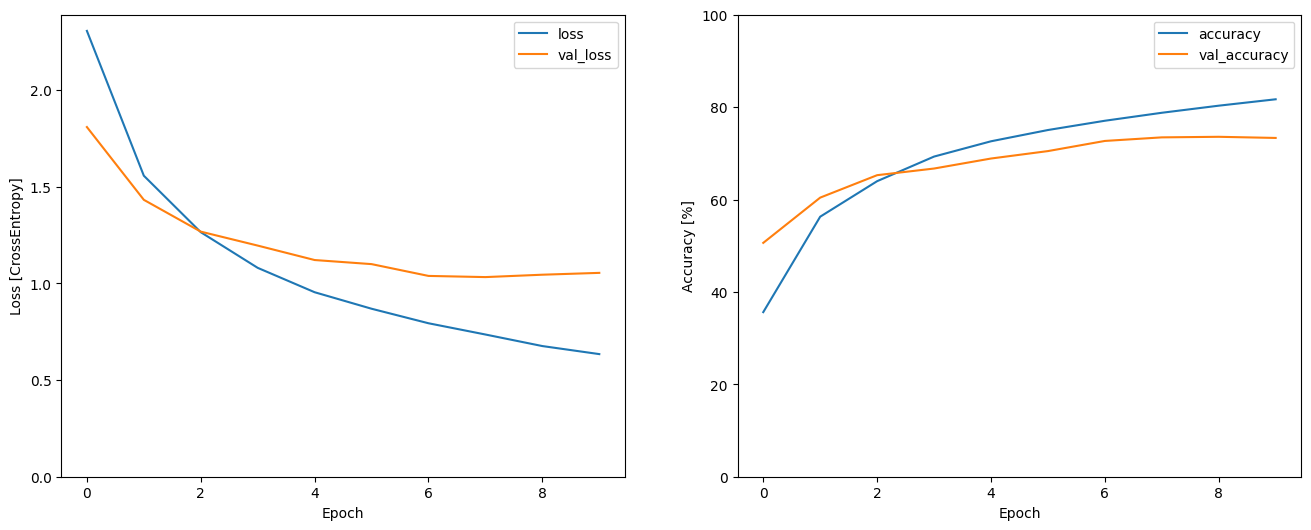

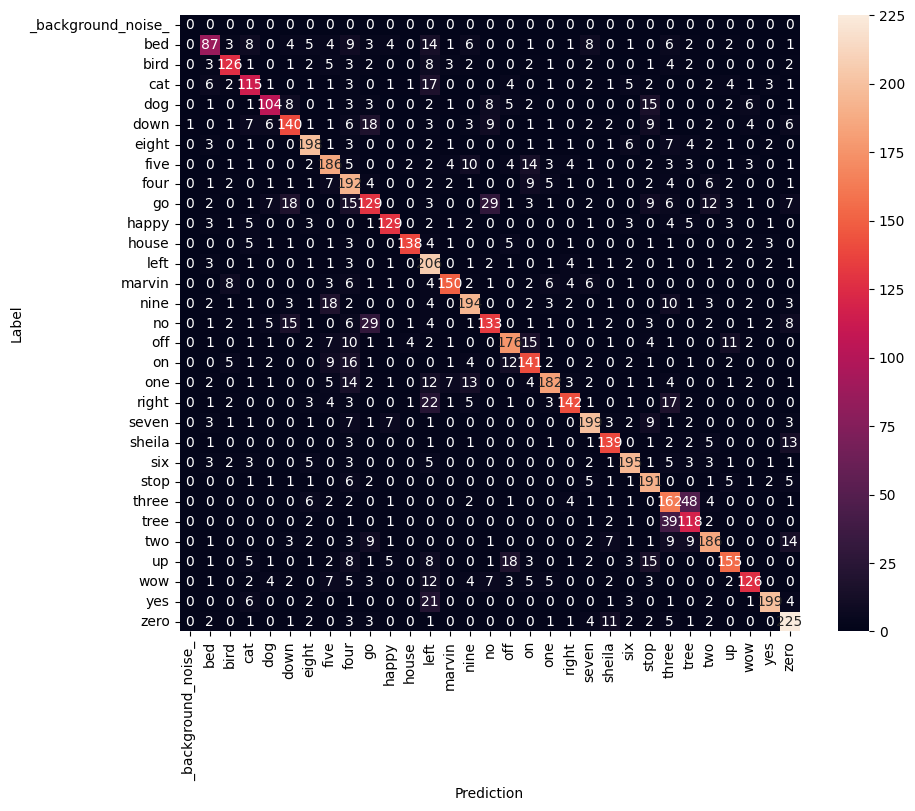

In [ ]:
training_pipeline(train_lineal_spectrogram_ds, val_lineal_spectrogram_ds, test_lineal_spectrogram_ds, base_model_lineal, epochs=10)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.2651 - loss: 2.5992 - val_accuracy: 0.5852 - val_loss: 1.4418
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6248 - loss: 1.3072 - val_accuracy: 0.6889 - val_loss: 1.0756
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7320 - loss: 0.9414 - val_accuracy: 0.7365 - val_loss: 0.8966
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7823 - loss: 0.7575 - val_accuracy: 0.7693 - val_loss: 0.7855
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8115 - loss: 0.6474 - val_accuracy: 0.7749 - val_loss: 0.7705
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8352 - loss: 0.5704 - val_accuracy: 0.7987 - val_loss: 0.7044
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8521 - loss: 0.5058 - val_accuracy: 0.7916 - val_loss: 0.7029
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8691 - loss: 0.4509 - val_accuracy: 

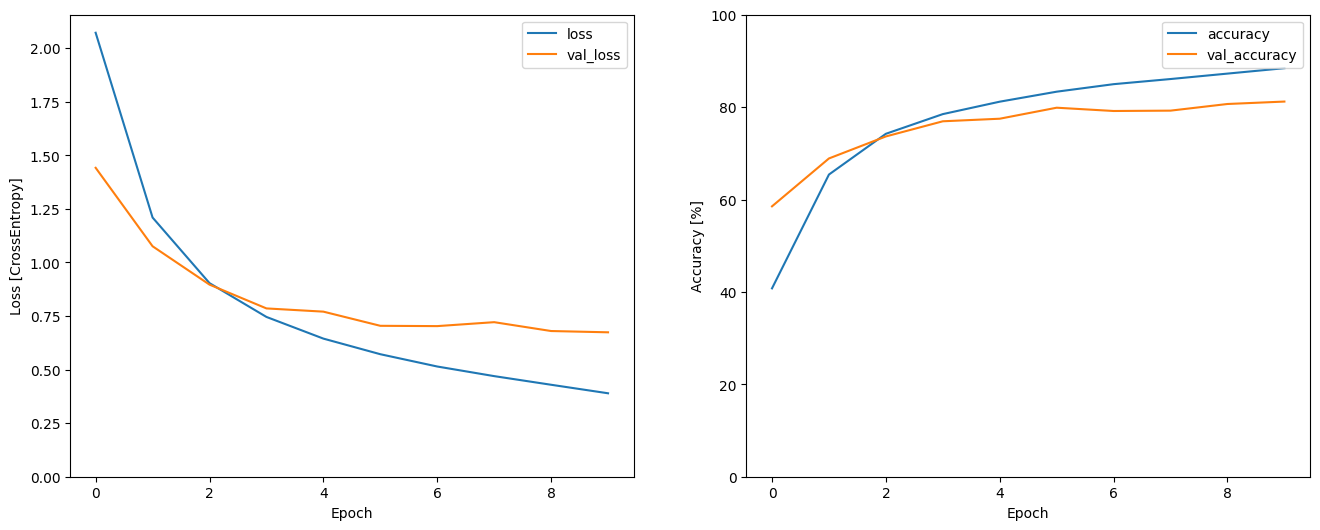

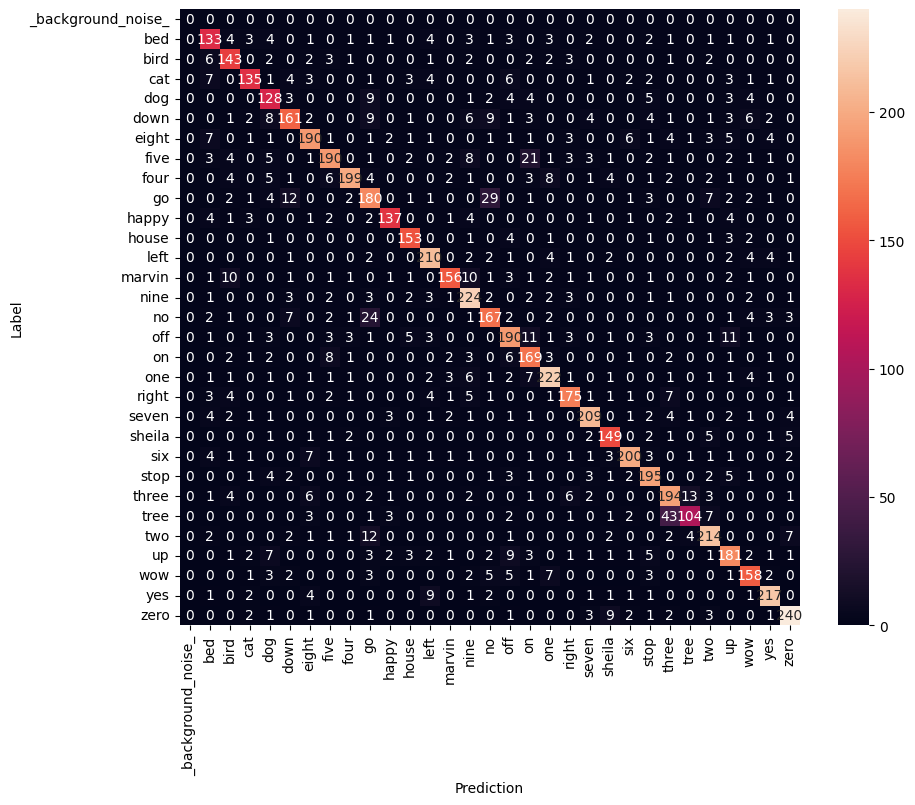

In [ ]:
training_pipeline(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, base_model_MEL, epochs=10)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.0826 - loss: 3.2479 - val_accuracy: 0.2522 - val_loss: 2.5812
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2801 - loss: 2.4932 - val_accuracy: 0.3478 - val_loss: 2.2404
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3611 - loss: 2.2009 - val_accuracy: 0.3770 - val_loss: 2.1126
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4042 - loss: 2.0439 - val_accuracy: 0.4301 - val_loss: 1.9576
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4347 - loss: 1.9498 - val_accuracy: 0.4149 - val_loss: 1.9632
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4605 - loss: 1.8566 - val_accuracy: 0.4732 - val_loss: 1.7983
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4753 - loss: 1.7906 - val_accuracy: 0.4638 - val_loss: 1.8040
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5022 - loss: 1.7232 - val_accuracy: 

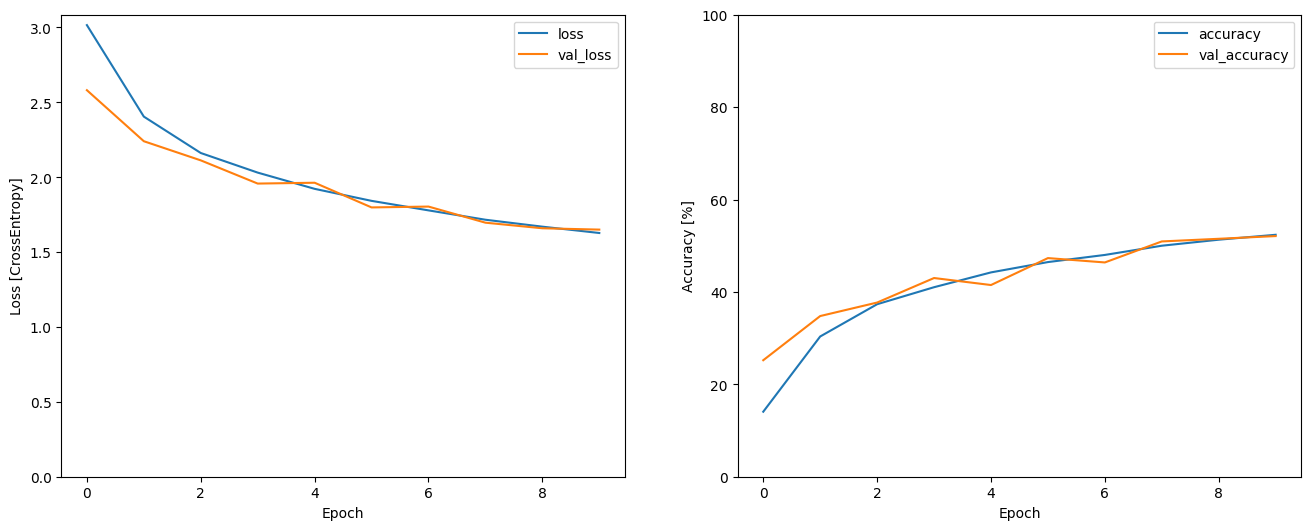

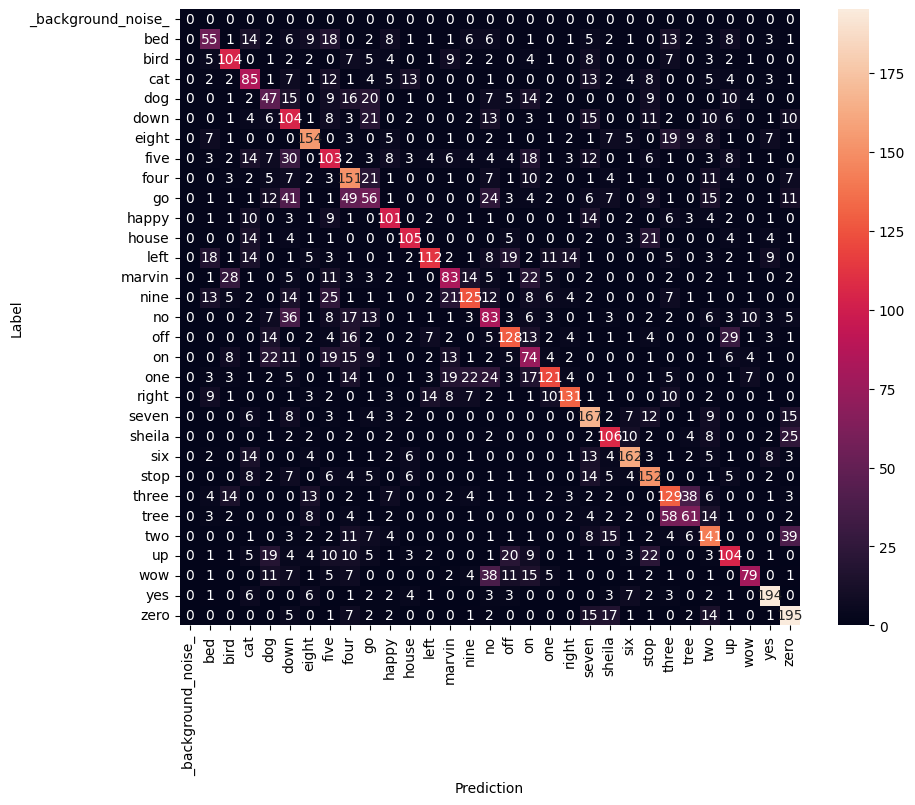

In [ ]:
training_pipeline(train_MFCC_ds, val_MFCC_ds, test_MFCC_ds, base_model_MFCC, epochs=10)

El model amb millors resultat és el espectrograma MEL que té un accuracy de 82%. Per tant, a partir d'ara treballarem amb espectrogrames MEL

# Proposta de models complexes

### Model amb capes convolucionals i regularització

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = example_spectrograms_MEL.shape[1:]
num_labels = len(label_names)

# Normalization (same as before)
norm_layer_MEL = layers.Normalization()
norm_layer_MEL.adapt(train_MEL_spectrogram_ds.map(lambda spec, label: spec))

Conv_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(48, 64),
    norm_layer_MEL,
    layers.Conv2D(24, 3, padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48, 3, padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_labels)
])
Conv_model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 48, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 48, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 64, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 32, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,546 (174.01 KB)

 Trainable params: 44,543 (174.00 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.0605 - loss: 3.3172 - val_accuracy: 0.2976 - val_loss: 2.4390
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3201 - loss: 2.2698 - val_accuracy: 0.5821 - val_loss: 1.4913
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5081 - loss: 1.6037 - val_accuracy: 0.6765 - val_loss: 1.1672
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5951 - loss: 1.3370 - val_accuracy: 0.7186 - val_loss: 0.9737
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6599 - loss: 1.1307 - val_accuracy: 0.7786 - val_loss: 0.7975
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7021 - loss: 0.9883 - val_accuracy: 0.7997 - val_loss: 0.7057
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7307 - loss: 0.8804 - val_accuracy: 0.8012 - val_loss: 0.6842
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7554 - loss: 0.8086 - val_accuracy: 

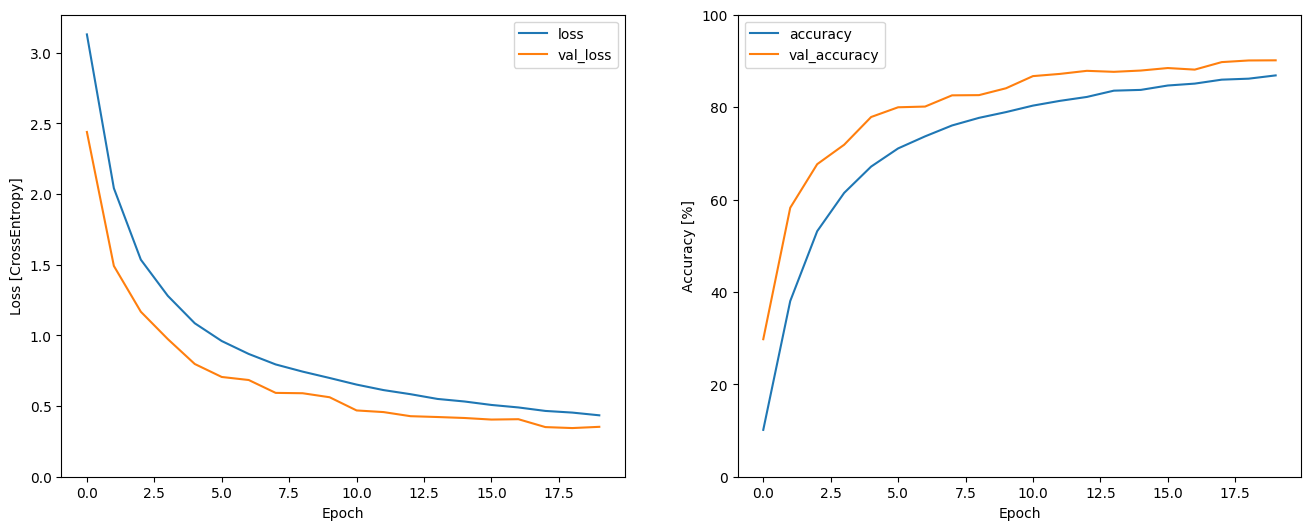

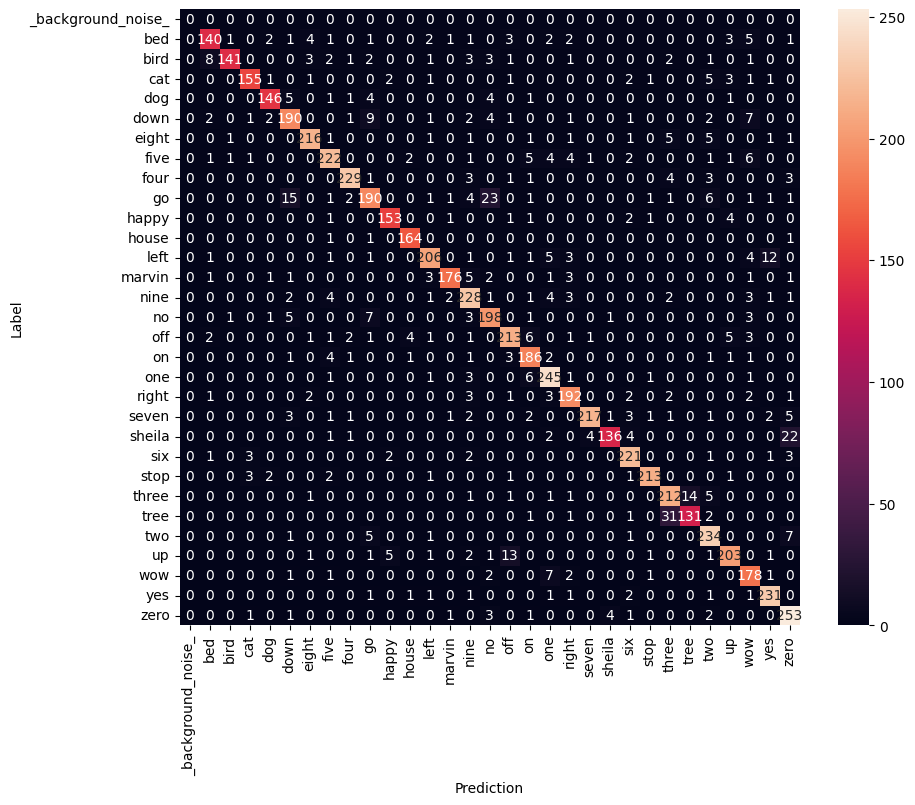

In [ ]:
training_pipeline(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, Conv_model, epochs=20)

#### Model amb capes convolucionals, recurrents i regularització

In [ ]:
crnn_bilstm_MEL = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(64, 64),
    norm_layer_MEL,
    layers.Conv2D(24, 3, padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(48, 3, padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.TimeDistributed(layers.Flatten()),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(num_labels)
])
crnn_bilstm_MEL.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 768)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       426,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,426 (1.71 MB)

 Trainable params: 447,423 (1.71 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.1314 - loss: 3.0115 - val_accuracy: 0.4802 - val_loss: 1.7380
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4701 - loss: 1.7241 - val_accuracy: 0.7149 - val_loss: 0.9618
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6792 - loss: 1.0465 - val_accuracy: 0.7822 - val_loss: 0.6969
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7713 - loss: 0.7496 - val_accuracy: 0.8413 - val_loss: 0.5114
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8221 - loss: 0.5830 - val_accuracy: 0.8608 - val_loss: 0.4665
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8511 - loss: 0.4882 - val_accuracy: 0.8782 - val_loss: 0.3911
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8733 - loss: 0.4100 - val_accuracy: 0.8834 - val_loss: 0.3779
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8912 - loss: 0.3490 - 

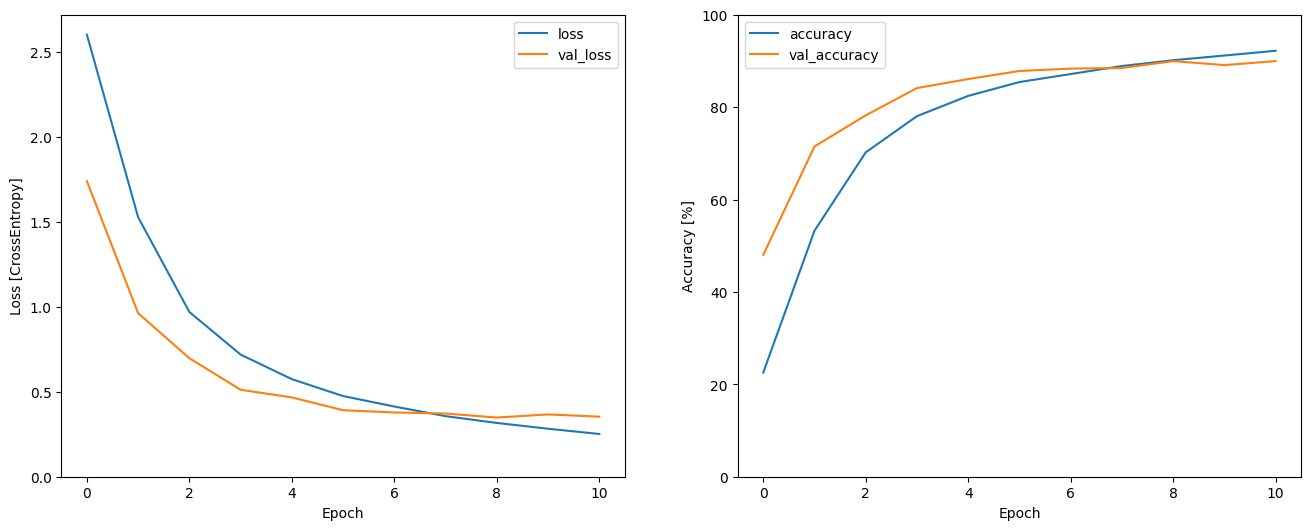

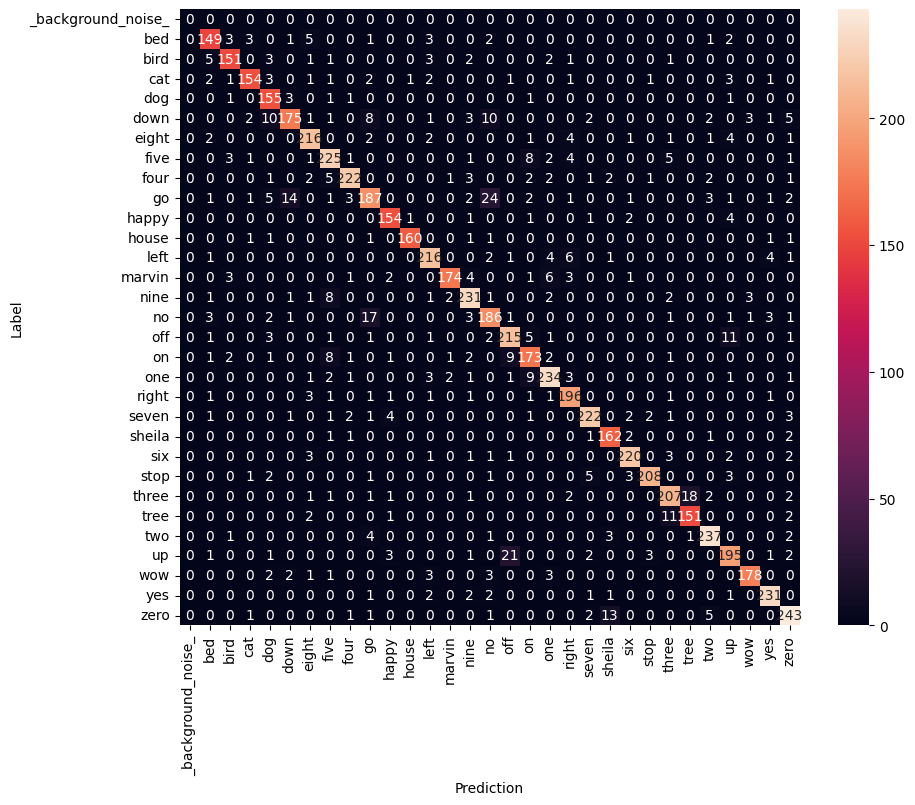

In [ ]:
training_pipeline(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, crnn_bilstm_MEL, epochs=20)

#### Models amb capes convolucionals, recurrents i transformers, i regularització i Layer Normalization

In [ ]:
EMBED_DIM  = 96
NUM_HEADS  = 3
FF_DIM     = 128
NUM_BLOCKS = 1
DROPOUT    = 0.20
T_TARGET   = 64

LSTM_UNITS = 64

pos_emb_layer = layers.Embedding(input_dim=T_TARGET, output_dim=EMBED_DIM)
pos_ids = tf.range(T_TARGET)

transformer_MEL = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, T_TARGET),
    layers.Conv2D(16, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 1)),
    layers.Dropout(0.10),

    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.10),
    layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name="freq_avg"),  # (B, T, C)
    layers.Dense(EMBED_DIM),

    layers.Lambda(lambda x: x + tf.expand_dims(pos_emb_layer(pos_ids), axis=0), name="add_pos"),
    layers.Dropout(DROPOUT),
    TransformerBlock(embed_dim=EMBED_DIM, num_heads=NUM_HEADS, ff_dim=FF_DIM, rate=DROPOUT),
    layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True)),
    layers.Dropout(0.20),

    layers.LayerNormalization(epsilon=1e-6),
    layers.GlobalAveragePooling1D(),

    layers.Dropout(DROPOUT),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(num_labels)
])

transformer_MEL.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_11 (Resizing)          │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 64, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ freq_avg (Lambda)               │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64, 96)         │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_pos (Lambda)                │ (None, 64, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 64, 96)         │       136,736 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 64, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 237,807 (928.93 KB)

 Trainable params: 237,711 (928.56 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.0522 - loss: 3.3586 - val_accuracy: 0.0848 - val_loss: 3.5147
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.3098 - loss: 2.2879 - val_accuracy: 0.5965 - val_loss: 1.3304
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.5682 - loss: 1.4065 - val_accuracy: 0.6901 - val_loss: 1.0182
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.6699 - loss: 1.0826 - val_accuracy: 0.7689 - val_loss: 0.7596
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7301 - loss: 0.9080 - val_accuracy: 0.7845 - val_loss: 0.7371
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7627 - loss: 0.7863 - val_accuracy: 0.8196 - val_loss: 0.5884
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7873 - loss: 0.7111 - val_accuracy: 0.8209 - val_loss: 0.5970
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8066 - loss: 0.6439 - 

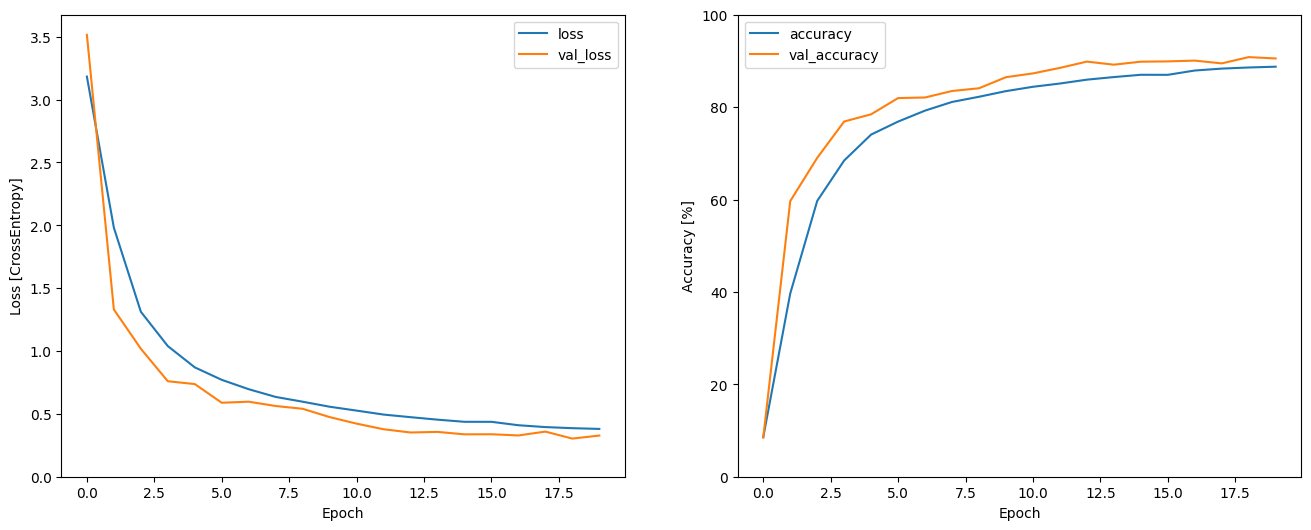

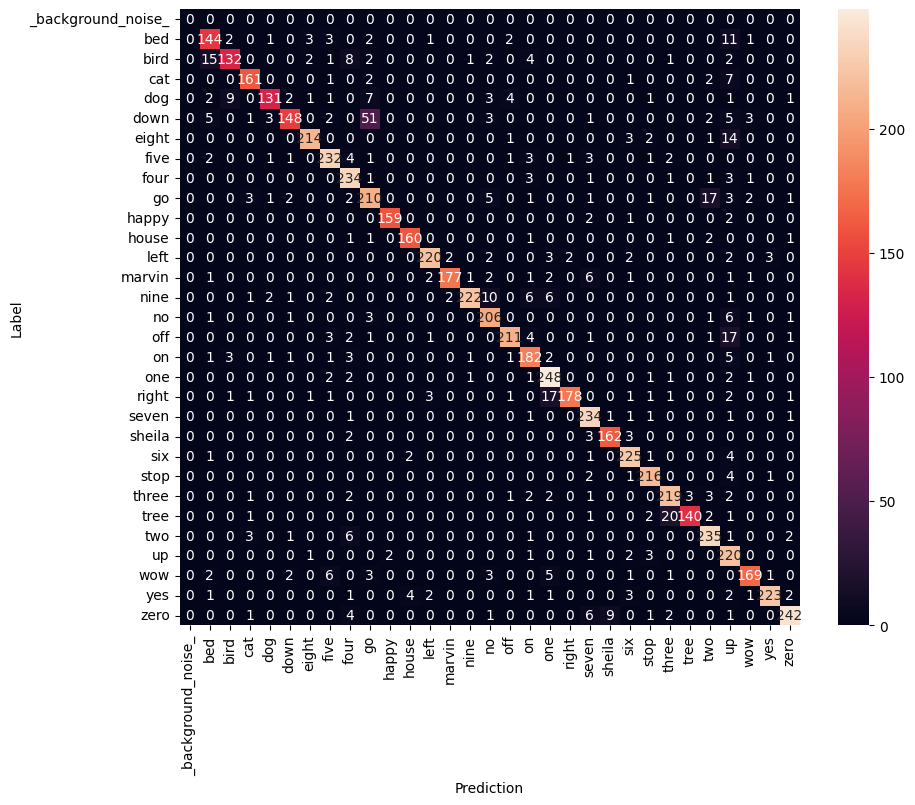

In [ ]:
training_pipeline(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, transformer_MEL, epochs=20)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = example_spectrograms_MEL.shape[1:]
num_labels = len(label_names)

norm_layer_MEL = layers.Normalization()
norm_layer_MEL.adapt(train_MEL_spectrogram_ds.map(lambda spec, label: spec))

crnn_bilstm_MEL_v2 = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(64, 64),
    norm_layer_MEL,
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Permute((2, 1, 3)),
    layers.TimeDistributed(layers.Flatten()),
    layers.Bidirectional(layers.LSTM(96)),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu",
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(num_labels)
])

crnn_bilstm_MEL_v2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 192)            │       860,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,738 (3.47 MB)

 Trainable params: 908,543 (3.47 MB)

 Non-trainable params: 195 (784.00 B)

# Cerca d'hiperparàmetres

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models
import itertools
import pandas as pd

input_shape = example_spectrograms_MEL.shape[1:]
num_labels = len(label_names)

def build_crnn_bilstm_MEL_v2(
    conv1_filters=32,
    conv2_filters=64,
    lstm_units=96,
    dense_units=128,
    drop1=0.1,
    drop2=0.2,
    drop_dense=0.3,
    l2=1e-4,
    lr=2e-4,
):
    norm_layer = layers.Normalization()
    norm_layer.adapt(train_MEL_spectrogram_ds.map(lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Resizing(64, 64),
        norm_layer,

        layers.Conv2D(conv1_filters, 3, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(drop1),

        layers.Conv2D(conv2_filters, 3, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(drop2),

        layers.Permute((2, 1, 3)),
        layers.TimeDistributed(layers.Flatten()),

        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dropout(drop_dense),

        layers.Dense(
            dense_units,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        ),
        layers.Dropout(drop_dense),

        layers.Dense(num_labels)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

grid = {
    "conv1_filters": [16, 32],
    "lstm_units": [64, 96],
    "dense_units": [64, 128],
    "lr": [1e-3, 2e-4],
}

EPOCHS = 5
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )
]

results = []
best = {"val_accuracy": -1.0, "cfg": None, "model": None}

for conv1, lstm, dense, lr in itertools.product(
    grid["conv1_filters"],
    grid["lstm_units"],
    grid["dense_units"],
    grid["lr"],
):
    cfg = {
        "conv1_filters": conv1,
        "lstm_units": lstm,
        "dense_units": dense,
        "lr": lr,
    }

    print("\n Hyperparemeters: ", cfg, )
    tf.keras.backend.clear_session()

    model = build_crnn_bilstm_MEL_v2(
        conv1_filters=conv1,
        lstm_units=lstm,
        dense_units=dense,
        lr=lr,
    )

    history = model.fit(
        train_MEL_spectrogram_ds,
        validation_data=val_MEL_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0,
    )

    best_val_acc = max(history.history["val_accuracy"])
    best_val_loss = min(history.history["val_loss"])

    row = {
        **cfg,
        "best_val_accuracy": best_val_acc,
        "best_val_loss": best_val_loss,
        "epochs_ran": len(history.history["val_accuracy"]),
    }
    results.append(row)

    if best_val_acc > best["val_accuracy"]:
        best["val_accuracy"] = best_val_acc
        best["cfg"] = cfg
        best["model"] = model

print("\n===== BEST CONFIG =====")
print(best["cfg"])
print("best_val_accuracy:", best["val_accuracy"])

best_model = best["model"]
val_loss, val_acc = best_model.evaluate(val_MEL_spectrogram_ds, verbose=0)
print("Final val_acc:", float(val_acc), "| val_loss:", float(val_loss))



 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 64, 'dense_units': 64, 'lr': 0.001}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 64, 'dense_units': 64, 'lr': 0.0002}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 64, 'dense_units': 128, 'lr': 0.001}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 64, 'dense_units': 128, 'lr': 0.0002}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 96, 'dense_units': 64, 'lr': 0.001}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 96, 'dense_units': 64, 'lr': 0.0002}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 96, 'dense_units': 128, 'lr': 0.001}

 Hyperparemeters:  {'conv1_filters': 16, 'lstm_units': 96, 'dense_units': 128, 'lr': 0.0002}

 Hyperparemeters:  {'conv1_filters': 32, 'lstm_units': 64, 'dense_units': 64, 'lr': 0.001}

 Hyperparemeters:  {'conv1_filters': 32, 'lstm_units': 64, 'dense_units': 64, 'lr': 0.0002}

 Hyperparemeters:  {'conv1_filters': 32, 'lstm_units': 64, 'dense_unit

In [23]:
crnn_bilstm_MEL_v3 = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(64, 64),
    norm_layer_MEL,
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 1)),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 1)),
    layers.Dropout(0.2),

    layers.Permute((2, 1, 3)),
    layers.TimeDistributed(layers.Flatten()),

    layers.Bidirectional(layers.LSTM(96)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu",
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(num_labels)
])


In [24]:
def training_pipeline_v2(train_data, val_data, test_data, model, epochs=10):

    steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
    if steps_per_epoch == tf.data.experimental.UNKNOWN_CARDINALITY:
        steps_per_epoch = 100

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch * epochs,
        alpha=1e-2
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4
    )
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
    )

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy'],
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

    print(model.evaluate(test_data, return_dict=True))

    y_pred = model.predict(test_data)
    y_pred = tf.argmax(y_pred, axis=1)

    y_true = tf.concat(list(test_data.map(lambda s,lab: lab)), axis=0)

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

    l = [[i, j] for i, j in zip(list(range(1, len(y_pred)+1)), y_pred.numpy().tolist())]
    df = pd.DataFrame(l, columns=['ID', 'labels'])
    df.to_csv('submission.csv', index=False)


Epoch 1/100
809/810 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9842 - loss: 0.0638
Epoch 1: val_accuracy improved from -inf to 0.95808, saving model to best.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9842 - loss: 0.0638 - val_accuracy: 0.9581 - val_loss: 0.2025
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9841 - loss: 0.0657
Epoch 2: val_accuracy improved from 0.95808 to 0.96318, saving model to best.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9841 - loss: 0.0657 - val_accuracy: 0.9632 - val_loss: 0.1960
Epoch 3/100
809/810 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9830 - loss: 0.0659
Epoch 3: val_accuracy did not improve from 0.96318
810/810 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9830 - loss: 0.0659 - val_accuracy: 0.9629 - val_loss: 0.1877
Epoch 4/100
809/810 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9831 - loss: 0.0682
Epoch 4: val_accuracy did not improve from 0.96318
810/810 ━━━━━━━━━━━━━━━━━━

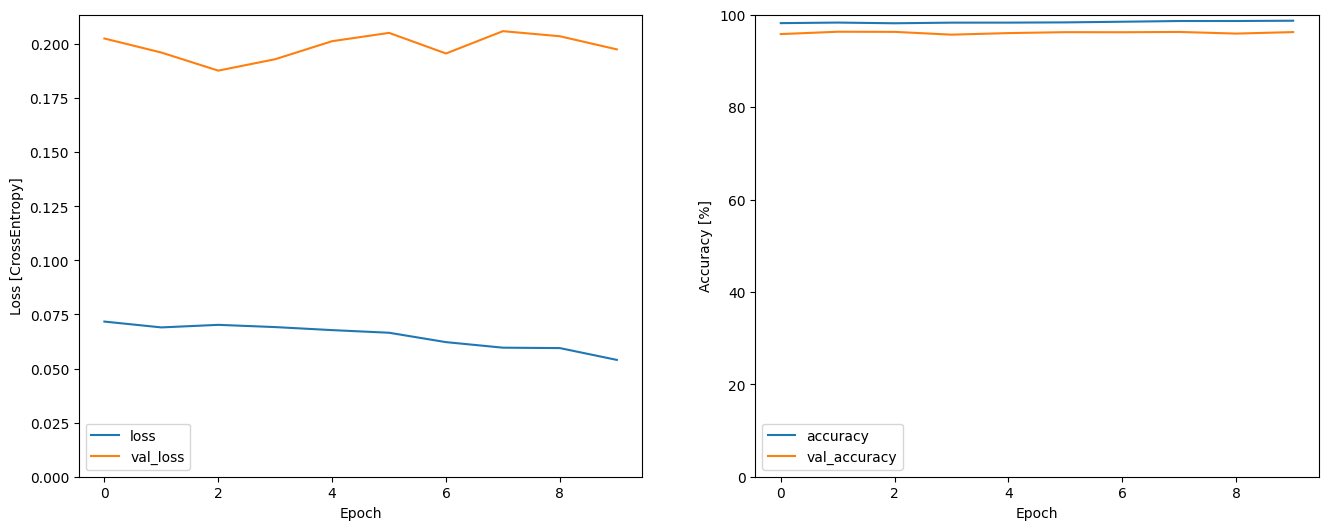

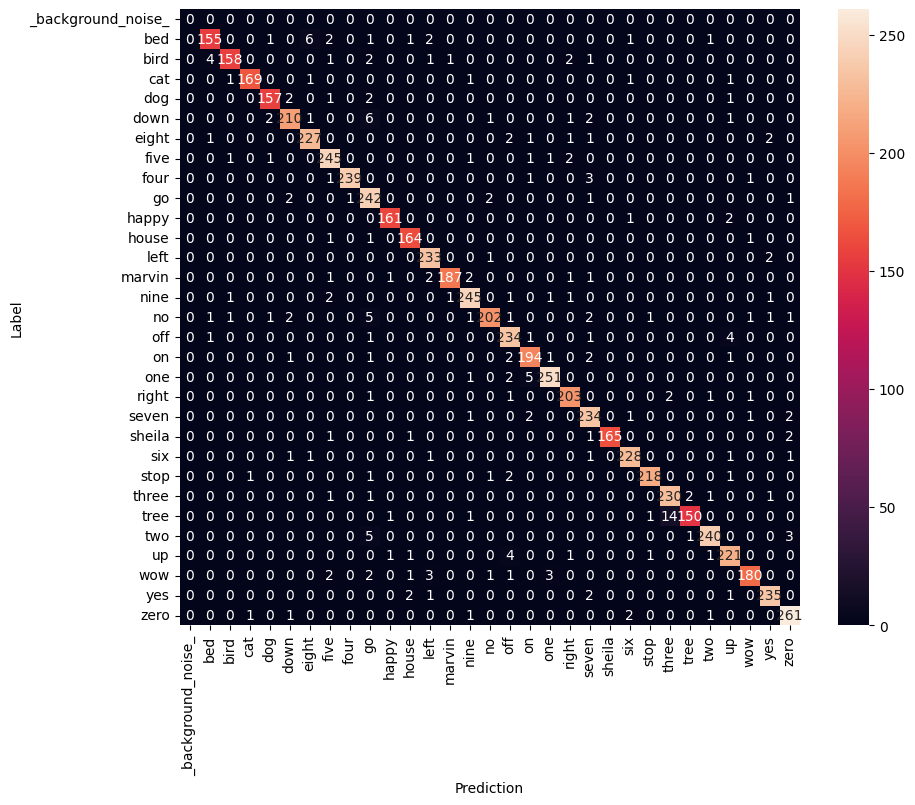

In [ ]:
training_pipeline_v2(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, crnn_bilstm_MEL_v2, epochs=100)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0979 - loss: 3.1509
Epoch 1: val_accuracy improved from -inf to 0.63707, saving model to best.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.0981 - loss: 3.1503 - val_accuracy: 0.6371 - val_loss: 1.2419
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6417 - loss: 1.1820
Epoch 2: val_accuracy improved from 0.63707 to 0.86231, saving model to best.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.6418 - loss: 1.1817 - val_accuracy: 0.8623 - val_loss: 0.4902
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8330 - loss: 0.5815
Epoch 3: val_accuracy improved from 0.86231 to 0.90718, saving model to best.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.8330 - loss: 0.5814 - val_accuracy: 0.9072 - val_loss: 0.3299
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8857 - loss: 0.4019
Epoch 4: val_accuracy improved from 0.90718 to 0.

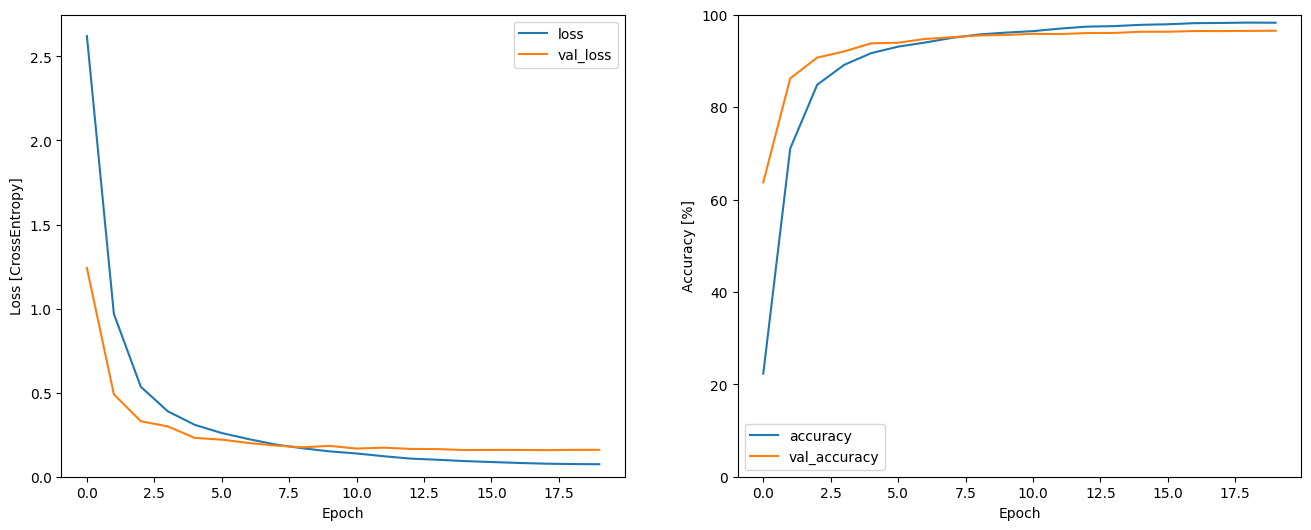

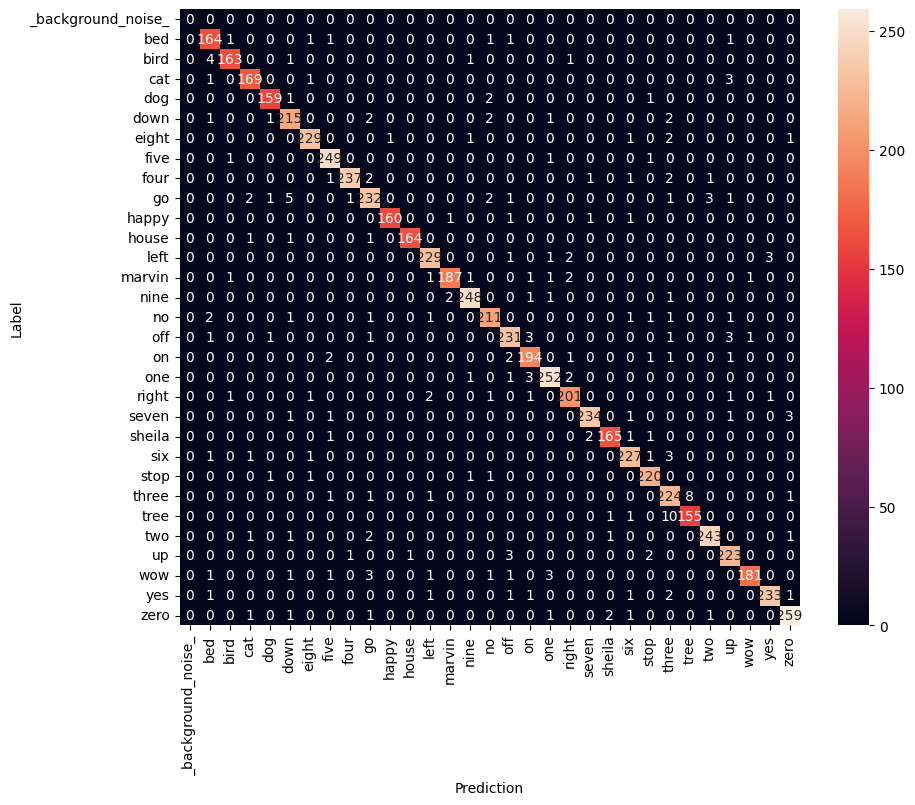

In [ ]:
training_pipeline_v2(train_MEL_spectrogram_ds, val_MEL_spectrogram_ds, test_MEL_spectrogram_ds, crnn_bilstm_MEL_v3, epochs=20)

# Extension: SpecAugment

In [25]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.9 MB/s eta 0:00:00


In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [27]:
def training_pipeline_v3(train_data, val_data, test_data, model, epochs=15): # Increased epochs slightly

    # 1. FIXED LR start (Let the callback handle the decay)
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-3,
        weight_decay=1e-4
    )

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    )

    model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'],)

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("best.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

    print(model.evaluate(test_data, return_dict=True))

    y_pred = model.predict(test_data)
    y_pred = tf.argmax(y_pred, axis=1)

    y_true = tf.concat(list(test_data.map(lambda s,lab: lab)), axis=0)

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

    l = [[i, j] for i, j in zip(list(range(1, len(y_pred)+1)), y_pred.numpy().tolist())]
    df = pd.DataFrame(l, columns=['ID', 'labels'])
    df.to_csv('submission.csv', index=False)


In [28]:
import tensorflow as tf
import tensorflow_io as tfio

def apply_spec_augment(spectrogram):
    spectrogram = tfio.audio.freq_mask(spectrogram, param=30)
    spectrogram = tfio.audio.time_mask(spectrogram, param=35)
    # Hem provat també de fer doble masking, les millores no eren gaire significatius
    #spectrogram = tfio.audio.freq_mask(spectrogram, param=15)
    #spectrogram = tfio.audio.time_mask(spectrogram, param=20)

    return spectrogram

def get_MEL_spectrogram_aug(waveform):
    waveform = tf.cast(waveform, tf.float32)
    if waveform.shape[-1] == 1:
        waveform = tf.squeeze(waveform, axis=-1)
    stft = tf.signal.stft(
        waveform,
        frame_length=255,
        frame_step=128,
        fft_length=512
    )
    magnitude = tf.abs(stft) ** 2
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=257,
        sample_rate=16000,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0
    )
    mel_spectrogram = tf.matmul(magnitude, mel_matrix)
    log_mel = tf.math.log(mel_spectrogram + 1e-6)
    log_mel = apply_spec_augment(log_mel)
    if len(log_mel.shape) == 3:
        return tf.transpose(log_mel, perm=[0, 2, 1])
    else:
        return tf.transpose(log_mel)


/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

In [29]:
def make_spec_ds_MEL(audio, label):
    mel = get_MEL_spectrogram(audio)
    mel = tf.expand_dims(mel, axis=-1)
    return mel, label

def make_spec_ds_MEL_with_augmentation(audio, label):
    mel = get_MEL_spectrogram_aug(audio)
    mel = tf.expand_dims(mel, axis=-1)
    return mel, label

options = tf.data.Options()
options.experimental_deterministic = False

train_MEL_spectrogram_ds2 = (
    train_ds
    .with_options(options)
    .unbatch()
    .shuffle(2000, reshuffle_each_iteration=True)
    .map(make_spec_ds_MEL_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(1)
)

val_MEL_spectrogram_ds2 = (
    val_ds
    .map(make_spec_ds_MEL, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(1)
)

test_MEL_spectrogram_ds2 = (
    test_ds
    .map(make_spec_ds_MEL, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(1)
)

Epoch 1/35
   1619/Unknown 128s 68ms/step - accuracy: 0.0526 - loss: 3.3563

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.30105, saving model to best.keras
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 144s 77ms/step - accuracy: 0.0526 - loss: 3.3562 - val_accuracy: 0.3011 - val_loss: 2.3646 - learning_rate: 0.0010
Epoch 2/35
1617/1619 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2118 - loss: 2.5729
Epoch 2: val_accuracy improved from 0.30105 to 0.60690, saving model to best.keras
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 99s 60ms/step - accuracy: 0.2119 - loss: 2.5726 - val_accuracy: 0.6069 - val_loss: 1.3506 - learning_rate: 0.0010
Epoch 3/35
1618/1619 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4345 - loss: 1.8225
Epoch 3: val_accuracy improved from 0.60690 to 0.82008, saving model to best.keras
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 98s 59ms/step - accuracy: 0.4346 - loss: 1.8223 - val_accuracy: 0.8201 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 4/35
1618/1619 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6321 - loss: 1.2175
Epoch 4: val_accuracy improved from 0.82008 to 0.8

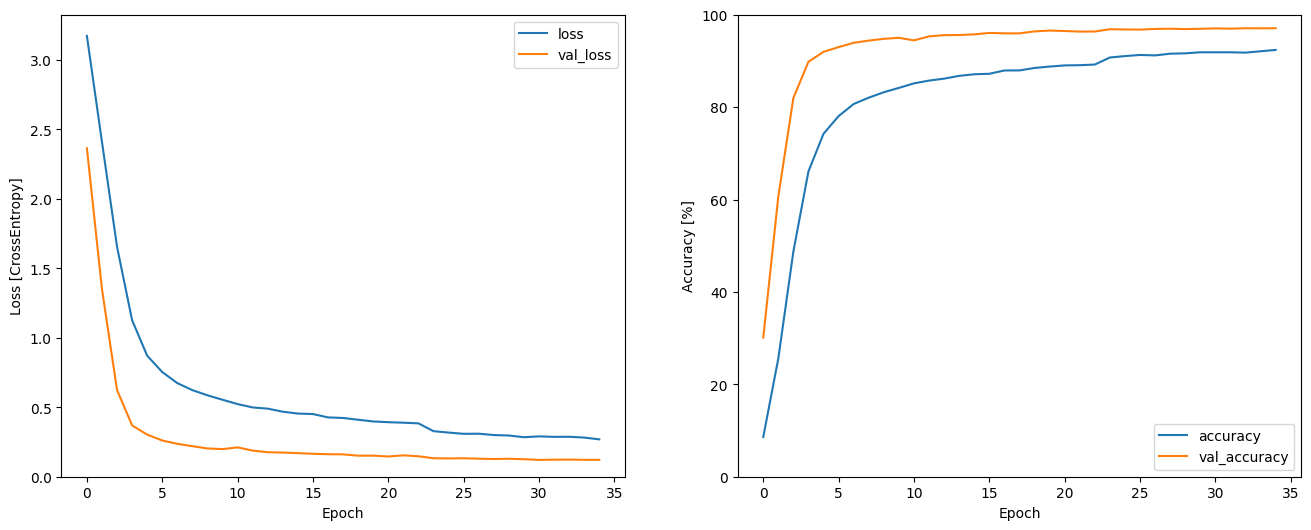

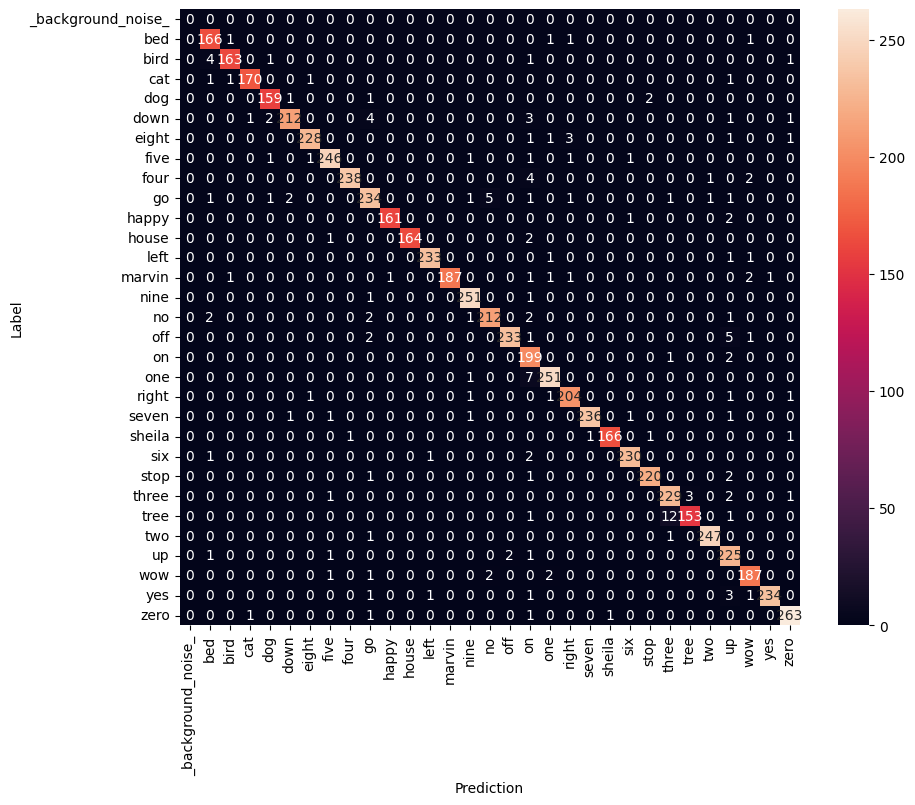

In [30]:
training_pipeline_v3(train_MEL_spectrogram_ds2, val_MEL_spectrogram_ds2, test_MEL_spectrogram_ds2, crnn_bilstm_MEL_v2, epochs=35)

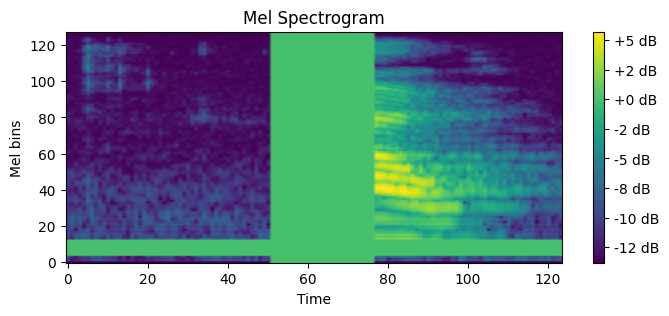

In [33]:
waveform = example_audio[i]
spectrogram = get_MEL_spectrogram_aug(waveform)
plot_MEL_spectrogram(spectrogram)